<a href="https://colab.research.google.com/github/ShresthaPriya/BigData/blob/main/2329818_PriyaShrestha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
import pyspark

In [ ]:
print(pyspark.__version__)

3.5.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Necessary import
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, sum, col, when,corr,rand
from pyspark.ml.feature import Imputer,VectorAssembler,StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression

In [ ]:
# create a SparkSession
spark = SparkSession.builder.appName("Life Expentancy").getOrCreate()

# Loading Dataset

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Big data/Coursework (Life-expectancy)/Life Expectancy Data.csv",header=True,inferSchema=True)

# EDA and Pre-Processing

# Pre-Processing

In [ ]:
df.show()

+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|    Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|        GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|Afghanistan|2015|Developing|            65.0|            263|           62|

In [ ]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life expectancy : double (nullable = true)
 |-- Adult Mortality: integer (nullable = true)
 |-- infant deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage expenditure: double (nullable = true)
 |-- Hepatitis B: integer (nullable = true)
 |-- Measles : integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- under-five deaths : integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total expenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |--  HIV/AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |--  thinness  1-19 years: double (nullable = true)
 |--  thinness 5-9 years: double (nullable = true)
 |-- Income composition of resources: double (nullable = true)
 |-- Schooling: double (nullable = true)



In [ ]:
# Number of rows
num_rows = df.count()

# Number of columns
num_cols = len(df.columns)

# Print shape
print((num_rows, num_cols))


(2938, 22)


In [ ]:
df.columns # Get the column names of the DataFrame

['Country',
 'Year',
 'Status',
 'Life expectancy ',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles ',
 ' BMI ',
 'under-five deaths ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 ' HIV/AIDS',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [ ]:
df.describe().show()  #descriptive statistics of the DataFrame

+-------+-----------+------------------+----------+-----------------+------------------+------------------+------------------+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+---------------------+-------------------+-------------------------------+------------------+
|summary|    Country|              Year|    Status| Life expectancy |   Adult Mortality|     infant deaths|           Alcohol|percentage expenditure|       Hepatitis B|          Measles |              BMI |under-five deaths |             Polio| Total expenditure|      Diphtheria |          HIV/AIDS|               GDP|          Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|         Schooling|
+-------+-----------+------------------+----------+-----------------+------------------+------------------+------------------+------

In [ ]:
df.dtypes

[('Country', 'string'),
 ('Year', 'int'),
 ('Status', 'string'),
 ('Life expectancy ', 'double'),
 ('Adult Mortality', 'int'),
 ('infant deaths', 'int'),
 ('Alcohol', 'double'),
 ('percentage expenditure', 'double'),
 ('Hepatitis B', 'int'),
 ('Measles ', 'int'),
 (' BMI ', 'double'),
 ('under-five deaths ', 'int'),
 ('Polio', 'int'),
 ('Total expenditure', 'double'),
 ('Diphtheria ', 'int'),
 (' HIV/AIDS', 'double'),
 ('GDP', 'double'),
 ('Population', 'double'),
 (' thinness  1-19 years', 'double'),
 (' thinness 5-9 years', 'double'),
 ('Income composition of resources', 'double'),
 ('Schooling', 'double')]

# Data Cleaning

1. **Checking duplicate rows and Columns**

In [ ]:
from pyspark.sql.functions import count

# Group by all columns and count
duplicates = df.groupBy(df.columns).count().filter("count > 1")

# Show duplicate records
duplicates.show()

#check for duplicate rows if contains
total_rows = df.count()
distinct_rows = df.dropDuplicates().count()

duplicate_count = total_rows - distinct_rows
print(f"Number of duplicate rows: {duplicate_count}")


+-------+----+------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+-----+
|Country|Year|Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|GDP|Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|count|
+-------+----+------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+-----+
+-------+----+------+----------------+---------------+-------------+-------+----------------------+----------

2.**Checking Categorical And Numerical columns**

In [ ]:
categorical_cols = [col for col, dtype in df.dtypes if dtype == 'string']
numerical_cols = [col for col, dtype in df.dtypes if dtype in ('int', 'double', 'float', 'bigint')]

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['Country', 'Status']
Numerical Columns: ['Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


1. Encoding Categorical Variable (status)

3. **Encoding the categorical column: Status**

In [ ]:
from pyspark.sql.functions import when, col

#if status is developed label it as 1 else 0.
# binary label encoding of the status column. (Label Encoding)
df = df.withColumn(
    "status",
    when(col("status") == "Developed", 1)
    .when(col("status") == "Developing", 0)
    .otherwise(col("status"))
)

df.select("status").distinct().show()

+------+
|status|
+------+
|     0|
|     1|
+------+



4. **Renaming the column name**


In [ ]:
df = df.toDF(*[c.strip().lower().replace(" ", "_") for c in df.columns])
print("Cleaned Column:\n", df.columns)

Cleaned Column:
 ['country', 'year', 'status', 'life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness__1-19_years', 'thinness_5-9_years', 'income_composition_of_resources', 'schooling']


# Visualization

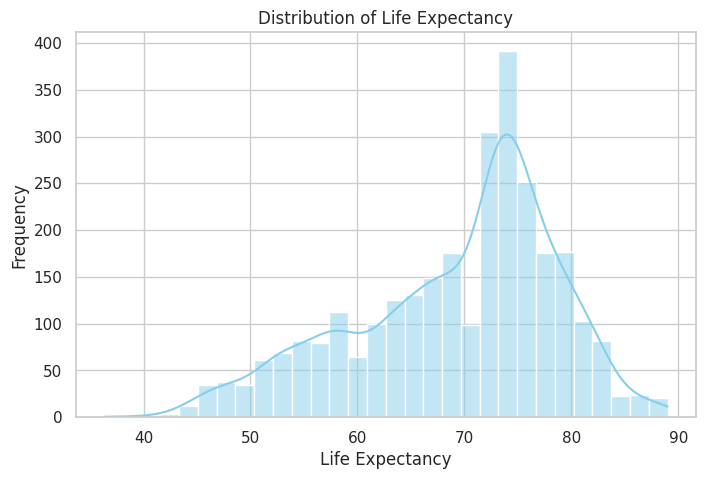

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas for visualizations
pdf = df.toPandas()

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Distribution of Target Variable
plt.figure(figsize=(8, 5))
sns.histplot(pdf['life_expectancy'], kde=True, color='skyblue')
plt.title("Distribution of Life Expectancy")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.show()


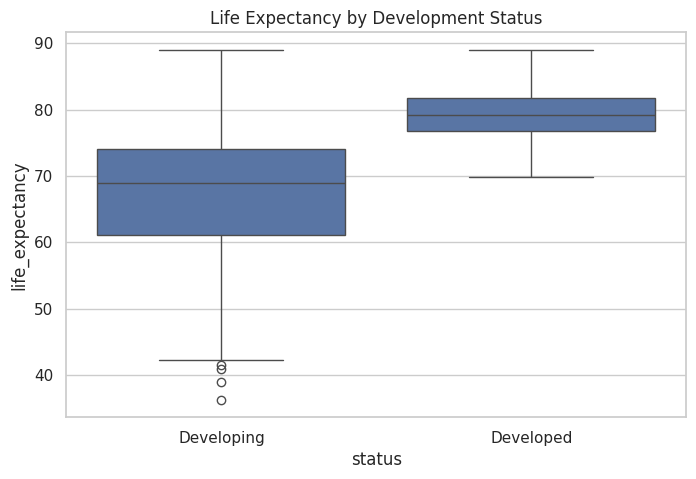

In [ ]:
# 2. Boxplot of Life Expectancy by Status
plt.figure(figsize=(8, 5))
sns.boxplot(x='status', y='life_expectancy', data=pdf)
plt.title("Life Expectancy by Development Status")
plt.xticks([0, 1], ['Developing', 'Developed'])
plt.show()

From the above box plot, outliers are identified:
For the developing country, outliers appiers at around 40 yearsm where one clear outlier is seen which is far from the lower whisker.
Median = around 70 Years
Q1 = around 60 and Q3 arount 75 years.
Where as for developed country, no outliers are seen.

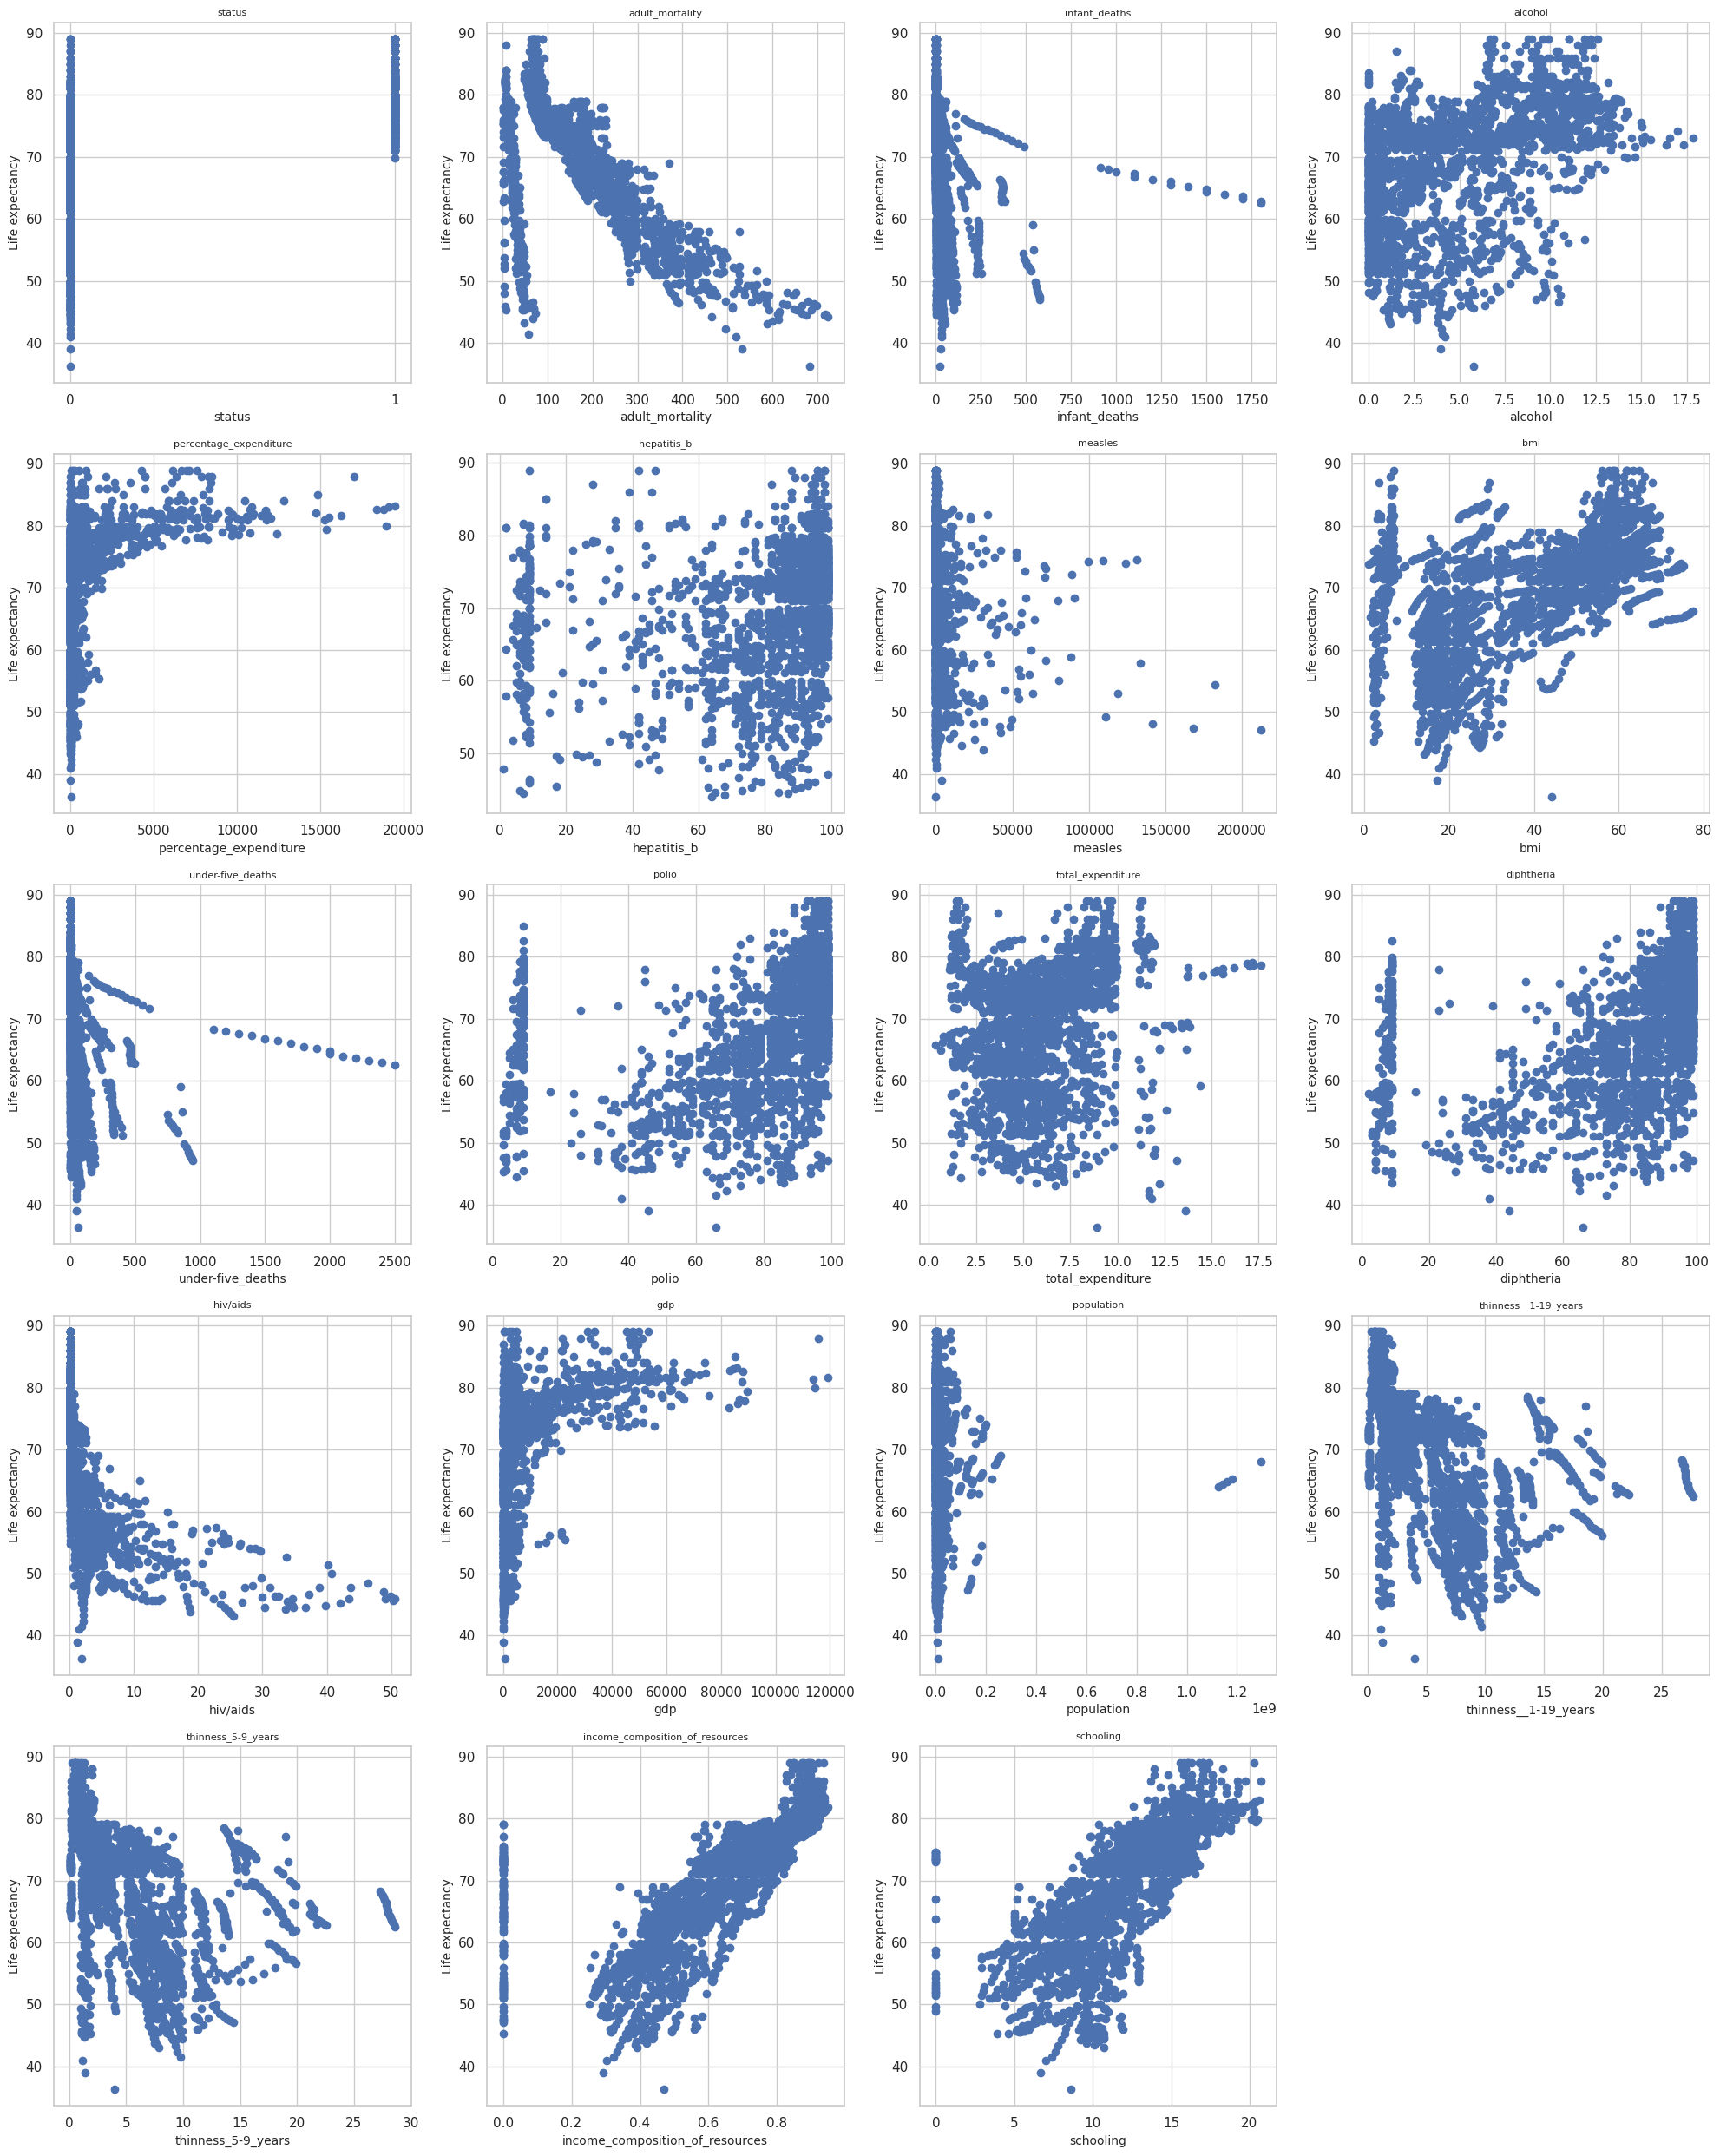

In [ ]:
import math
# Collect features and target (excluding 'life_expectancy', 'country', and 'year')
feature_columns = [c for c in df.columns if c not in ['life_expectancy', 'country', 'year']]

# Extract data
features_data = {col_name: df.select(col_name).rdd.flatMap(lambda x: x).collect() for col_name in feature_columns}
target_data = df.select('life_expectancy').rdd.flatMap(lambda x: x).collect()

# Dynamically calculate rows needed
n_features = len(feature_columns)
cols = 4  # Number of columns per row
rows = math.ceil(n_features / cols)  # Adjust rows based on features

# Plot
fig = plt.figure(figsize=(20, 5 * rows), dpi=100)  # Adjust height dynamically

for index, feature_name in enumerate(feature_columns):
    plt.subplot(rows, cols, index + 1)
    plt.scatter(features_data[feature_name], target_data)
    plt.ylabel('Life expectancy', size=10)
    plt.xlabel(feature_name, size=10)
    plt.title(feature_name, fontsize=8)

plt.tight_layout()
plt.show()

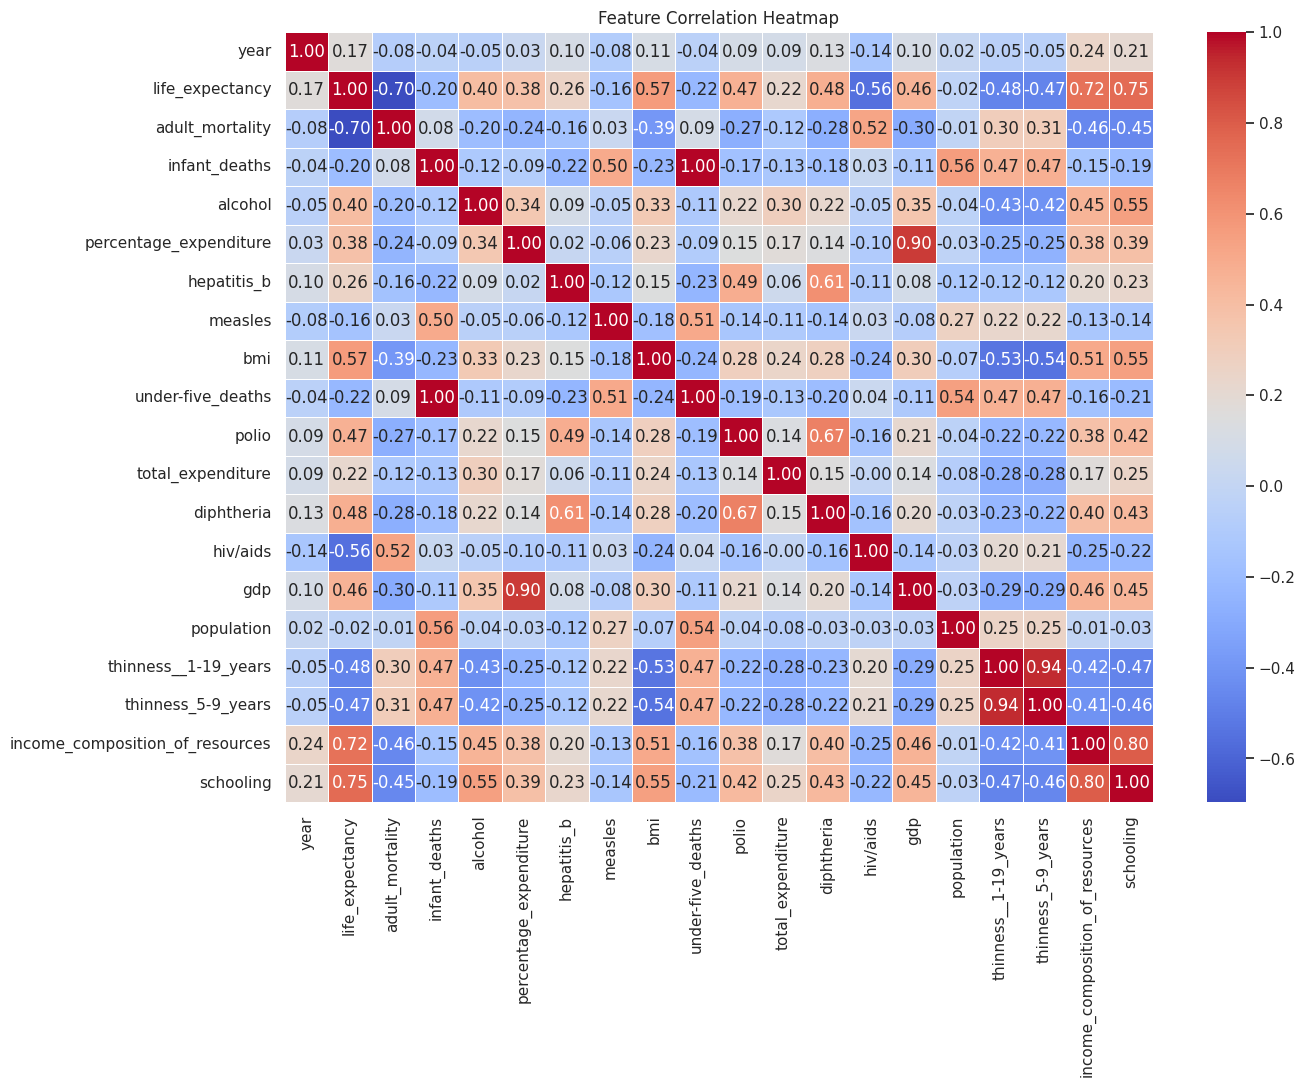

In [ ]:
# Heatmap of Correlations
plt.figure(figsize=(14, 10))
correlation_matrix = pdf.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()



Correlation with life-expectancy:
Popution shows weak/almost no correlation with majority of variables as well as with life expectancy (-0.02).
With year also it has very weak correaltion of 0.17 only.
0.22 with total expenditure, weak relation.
Measles -0.16 low correlation.

with adult mortality, HIV/AIDS it has strong negative correaltion, while with schooling, income and BMI it has strong to moderate correlation.

2. Handling Missing Value



In [ ]:
null_counts = df.select([sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+-------+---+-----------------+-----+-----------------+----------+--------+---+----------+--------------------+------------------+-------------------------------+---------+
|country|year|status|life_expectancy|adult_mortality|infant_deaths|alcohol|percentage_expenditure|hepatitis_b|measles|bmi|under-five_deaths|polio|total_expenditure|diphtheria|hiv/aids|gdp|population|thinness__1-19_years|thinness_5-9_years|income_composition_of_resources|schooling|
+-------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+-------+---+-----------------+-----+-----------------+----------+--------+---+----------+--------------------+------------------+-------------------------------+---------+
|      0|   0|     0|             10|             10|            0|    194|                     0|        553|      0| 34|                0|   19|        

In [ ]:
from pyspark.ml.feature import Imputer

# Identify only numeric columns (excluding "Status" or any strings)
numeric_cols = [col_name for (col_name, dtype) in df.dtypes
                if dtype in ("double", "int")]

# Apply imputer only on numeric columns
imputer = Imputer(strategy="median", inputCols=numeric_cols, outputCols=numeric_cols)
df_imputed = imputer.fit(df).transform(df)


In [ ]:
from pyspark.sql.functions import col, sum, when

# Count nulls in each column
df_imputed.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_imputed.columns
]).show()


+-------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+-------+---+-----------------+-----+-----------------+----------+--------+---+----------+--------------------+------------------+-------------------------------+---------+
|country|year|status|life_expectancy|adult_mortality|infant_deaths|alcohol|percentage_expenditure|hepatitis_b|measles|bmi|under-five_deaths|polio|total_expenditure|diphtheria|hiv/aids|gdp|population|thinness__1-19_years|thinness_5-9_years|income_composition_of_resources|schooling|
+-------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+-------+---+-----------------+-----+-----------------+----------+--------+---+----------+--------------------+------------------+-------------------------------+---------+
|      0|   0|     0|              0|              0|            0|      0|                     0|          0|      0|  0|                0|    0|        

In [ ]:
df.show()

+-----------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+
|    country|year|status|life_expectancy|adult_mortality|infant_deaths|alcohol|percentage_expenditure|hepatitis_b|measles| bmi|under-five_deaths|polio|total_expenditure|diphtheria|hiv/aids|        gdp| population|thinness__1-19_years|thinness_5-9_years|income_composition_of_resources|schooling|
+-----------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+
|Afghanistan|2015|     0|           65.0|            263|           62|   0.01|           71.27962362|         6

Optional box plot

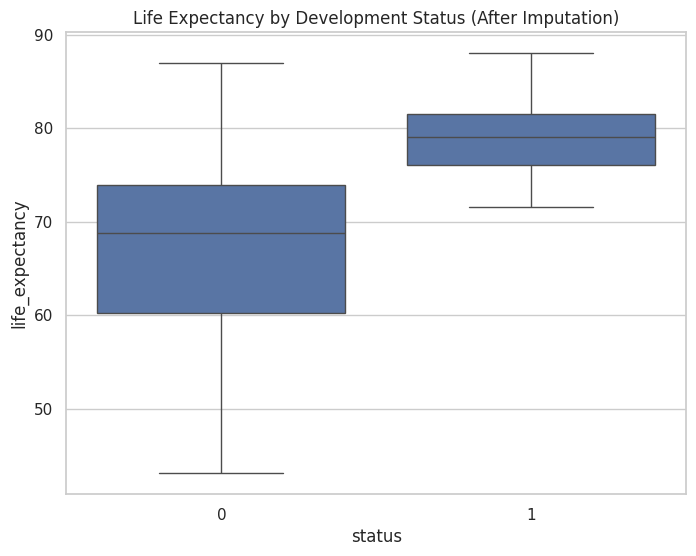

In [ ]:
# Convert to Pandas
df_pd = df_imputed.select("status", "life_expectancy").toPandas()

# Sample to avoid memory issues
df_pd = df_imputed.select("status", "life_expectancy").sample(False, 0.1).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x="status", y="life_expectancy", data=df_pd)
plt.title("Life Expectancy by Development Status (After Imputation)")
plt.show()

# Visualization after handling missing values

1. Correlation Heatmap



Features 'gdp' and 'percentage_expenditure' are highly correlated with correlation coefficient = 0.90
Features 'thinness_5-9_years' and 'thinness__1-19_years' are highly correlated with correlation coefficient = 0.94


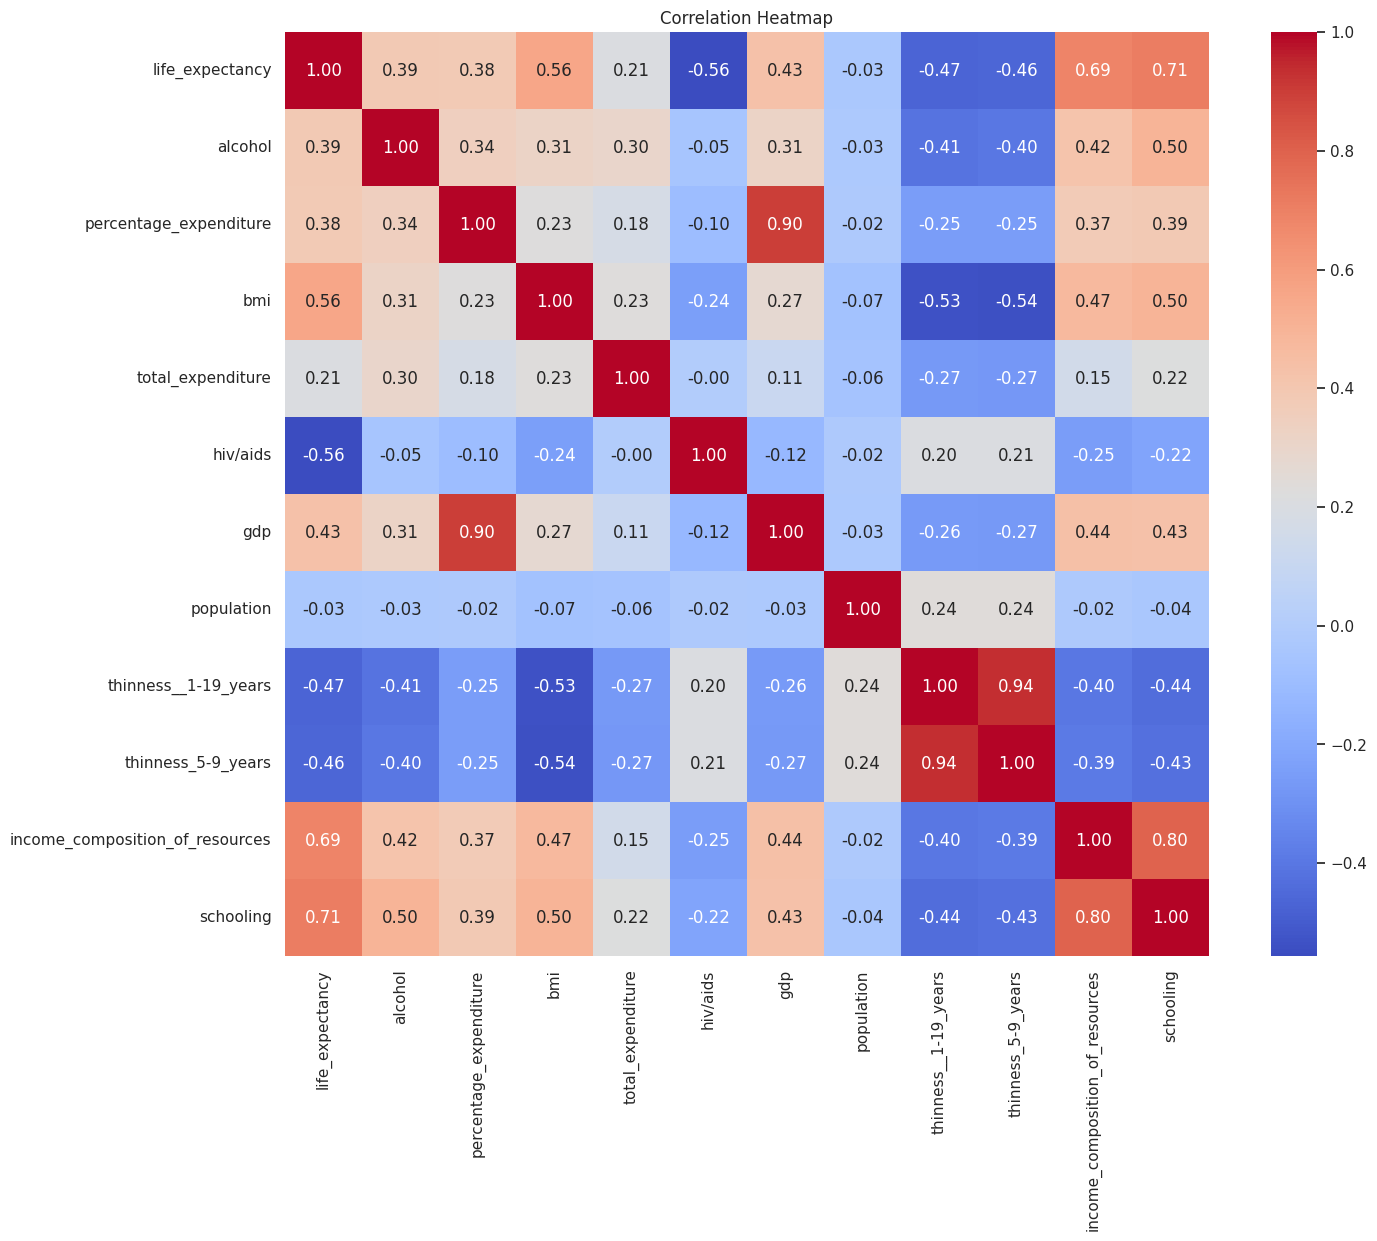

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
pandas_df = df_imputed.toPandas()


# Drop non-numeric columns (optional: 'Country', 'Status', etc.)
numeric_df = pandas_df.select_dtypes(include=['float64', 'int64'])

# Drop rows with missing values (optional)
numeric_df = numeric_df.dropna()

# 1. Compute correlation matrix
corr_matrix = numeric_df.corr()

# 2. Find feature pairs with high correlation
high_corr_pairs = []

# Only look at upper triangle of the matrix (to avoid duplicate pairs)
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:  # Threshold for "high" correlation
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr_pairs.append((colname1, colname2, corr_value))

# Print the highly correlated pairs
for col1, col2, corr_val in high_corr_pairs:
    print(f"Features '{col1}' and '{col2}' are highly correlated with correlation coefficient = {corr_val:.2f}")

# 3. Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()


The correlation heatmap suggests Features 'GDP' and 'percentage expenditure' are highly correlated with correlation coefficient = 0.90
Features ' thinness 5-9 years' and ' thinness  1-19 years' are highly correlated with correlation coefficient = 0.94.


Strong negative correlation of life expectancy:
1. HIV/AIDS : -0.56

String positive correation:

1. Schooling: 0.71
2. BMI: 0.56
3. Income composition of resources:0.69

# Dropping the features according to heatmap correlation

In [ ]:
import re

# clean column names
new_columns = []
for c in df_imputed.columns:
    clean_c = re.sub(' +', ' ', c.strip())  # remove extra spaces
    new_columns.append(clean_c)

for old_name, new_name in zip(df_imputed.columns, new_columns):
    df_imputed = df_imputed.withColumnRenamed(old_name, new_name)

# Drop the columns
cols_to_drop = [
    "population",
    "total_expenditure",
    "thinness_5-9_years",
    "Measles",
    "Alcohol",
    "under-five_deaths",
    "Country",
    "Year"
]

df_cleaned = df_imputed.drop(*cols_to_drop)

#display results
print("Schema after cleaning and dropping columns:")
df_cleaned.printSchema()

print("Data after cleaning and dropping columns:")
df_cleaned.show(5)


Schema after cleaning and dropping columns:
root
 |-- status: string (nullable = true)
 |-- life_expectancy: double (nullable = true)
 |-- adult_mortality: integer (nullable = true)
 |-- infant_deaths: integer (nullable = true)
 |-- percentage_expenditure: double (nullable = true)
 |-- hepatitis_b: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- polio: integer (nullable = true)
 |-- diphtheria: integer (nullable = true)
 |-- hiv/aids: double (nullable = true)
 |-- gdp: double (nullable = true)
 |-- thinness__1-19_years: double (nullable = true)
 |-- income_composition_of_resources: double (nullable = true)
 |-- schooling: double (nullable = true)

Data after cleaning and dropping columns:
+------+---------------+---------------+-------------+----------------------+-----------+----+-----+----------+--------+----------+--------------------+-------------------------------+---------+
|status|life_expectancy|adult_mortality|infant_deaths|percentage_expenditure|hepatitis_b|

Population dropped as it is highly corelated with GDP so we put GDP and drop population, did the same for thinnes 5_9 and total expenditure.



# Split into Train and Test data

In [ ]:
# Rename 'Life expectancy' to 'life_expectancy'
df_cleaned = df_cleaned.withColumnRenamed('Life expectancy', 'life_expectancy')

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select numerical columns
numerical_cols = [col for col, dtype in df_cleaned.dtypes if dtype in ['int', 'double']]

# Step 2: Remove the target column from features
numerical_cols = [col for col in numerical_cols if col != 'life_expectancy']

print("Final numerical columns used as features:\n", numerical_cols)
print("\n")
# Assemble features
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
df_transformed = assembler.transform(df_cleaned).select('features', 'life_expectancy')


Final numerical columns used as features:
 ['adult_mortality', 'infant_deaths', 'percentage_expenditure', 'hepatitis_b', 'bmi', 'polio', 'diphtheria', 'hiv/aids', 'gdp', 'thinness__1-19_years', 'income_composition_of_resources', 'schooling']




In [ ]:
# Select features and life_expectancy (dependent variable)
final_dframe = df_transformed.select('features', 'life_expectancy')

# Show the result to ensure it worked
final_dframe.show(5)

+--------------------+---------------+
|            features|life_expectancy|
+--------------------+---------------+
|[263.0,62.0,71.27...|           65.0|
|[271.0,64.0,73.52...|           59.9|
|[268.0,66.0,73.21...|           59.9|
|[272.0,69.0,78.18...|           59.5|
|[275.0,71.0,7.097...|           59.2|
+--------------------+---------------+
only showing top 5 rows



In [ ]:
#Split the dataset into train and test in 70/30 ration
train_data, test_data = final_dframe.randomSplit([0.7, 0.3], seed=42) #seed to get the same split each time when we run

In [ ]:
print("Descriptive Statistic of training data:")
train_data.describe().show()
print('\n')
print("Descriptive Statistic of testing data:")
test_data.describe().show()

Descriptive Statistic of training data:
+-------+-----------------+
|summary|  life_expectancy|
+-------+-----------------+
|  count|             2112|
|   mean|69.42410037878793|
| stddev|9.429343399961155|
|    min|             36.3|
|    max|             89.0|
+-------+-----------------+



Descriptive Statistic of testing data:
+-------+-----------------+
|summary|  life_expectancy|
+-------+-----------------+
|  count|              826|
|   mean| 68.7504842615012|
| stddev|9.699071171168331|
|    min|             44.6|
|    max|             89.0|
+-------+-----------------+



# Predictive Models

#1. Multiple Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

# Build a Multiple Linea999r Regression model
lr = LinearRegression(featuresCol='features', labelCol='life_expectancy')

# Fit the model
model = lr.fit(train_data)

In [ ]:
# Get the coefficients (without intercept)
coefficients = model.coefficients.toArray()

# Create the DataFrame with the correct number of columns (13)
coeff_df = pd.DataFrame({'coefficients': coefficients}, index=numerical_cols)
coeff_df


,coefficients
adult_mortality,-0.021356
infant_deaths,-0.000781
percentage_expenditure,0.000175
hepatitis_b,-0.017888
bmi,0.046014
polio,0.036107
diphtheria,0.043792
hiv/aids,-0.461336
gdp,0.000033
thinness__1-19_years,-0.124284


A negative coefficient means that as adult mortality increases, life expectancy decreases. And the unit says...decrease or increase by that much unit.So Life expectancy decreases by 0.002 years when the adult mortality increase.

In [ ]:
#Evaluate the model in test data
evaluate_model = model.evaluate(test_data)

#show residual on test dat
evaluate_model.residuals.show()

+--------------------+
|           residuals|
+--------------------+
| -2.2109312136881556|
|  0.9639434335340695|
|  -6.350649739160303|
|-0.16180858560659317|
|  -8.626134141764922|
|  -8.904427168014223|
|  -3.692996436685206|
| -0.8875453194902718|
| -10.244806643651387|
| -10.853856653444609|
|  -4.919141348689081|
|  -8.410421117703805|
| -13.614525634089233|
|   2.655934743913676|
|   0.646100027028794|
| -0.2797458602858711|
|  -2.344805108854132|
| 0.06322849406512887|
|  -0.554868420307173|
| -0.5197708464623361|
+--------------------+
only showing top 20 rows



In [ ]:
feature_data = test_data.select('features') #select the feature data from test data

pred = model.transform(feature_data) #make prediction

pred.show()  #show the generated prediction by the model


# Predict on test data
predictions = model.transform(test_data)

# Select required columns
results = predictions.select("life_expectancy", "prediction", (predictions.life_expectancy - predictions.prediction).alias("residuals"))

# Show formatted output
results.show(truncate=False)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[1.0,0.0,2048.557...| 78.21093121368816|
|[1.0,1.0,868.3713...| 76.53605656646593|
|[1.0,1.0,2943.375...|  84.3506497391603|
|[1.0,2.0,584.0993...|  78.0618085856066|
|[2.0,0.0,62.08343...| 77.72613414176492|
|[2.0,0.0,97.87193...| 75.00442716801422|
|[2.0,0.0,240.4851...|  71.2929964366852|
|[2.0,1300.0,0.844...| 66.88754531949027|
|[3.0,3.0,0.0,91.0...| 66.54480664365138|
|[3.0,17.0,12.2518...| 77.25385665344461|
|[3.0,18.0,44.2568...| 64.61914134868908|
|[4.0,70.0,39.7521...|  62.2104211177038|
|[4.0,556.0,6.4162...|62.814525634089236|
|[5.0,0.0,764.5440...| 79.74406525608633|
|[6.0,0.0,230.2524...|  78.6538999729712|
|[6.0,0.0,2084.255...| 82.27974586028587|
|[6.0,0.0,14714.82...| 84.44480510885413|
|[6.0,1.0,4348.335...| 82.13677150593487|
|[6.0,2.0,5219.668...| 82.35486842030717|
|[6.0,2.0,5439.691...| 82.51977084646234|
+--------------------+------------

In [ ]:
#display in the evaluation matrix

print("MAE", evaluate_model.meanAbsoluteError)
print("MSE", evaluate_model.meanSquaredError)
print("RMSE", evaluate_model.rootMeanSquaredError)
print("R2", evaluate_model.r2)
print("Adj R2: ", evaluate_model.r2adj)

MAE 3.1590295187183224
MSE 18.51683197338581
RMSE 4.30311886582114
R2 0.8029245657829778
Adj R2:  0.8000157032853096


#2. **Random** **Forest**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
#initialise the random forest model
rf = RandomForestRegressor(featuresCol='features', labelCol='life_expectancy', numTrees=100, seed=42)

#train and fit the model in train data
rf_model= rf.fit(train_data)


In [ ]:
predictions_rf = rf_model.transform(test_data)
predictions_rf.show()

+--------------------+---------------+-----------------+
|            features|life_expectancy|       prediction|
+--------------------+---------------+-----------------+
|[1.0,0.0,2048.557...|           76.0|77.23356211047435|
|[1.0,1.0,868.3713...|           77.5|74.15627544150975|
|[1.0,1.0,2943.375...|           78.0|81.32844117317778|
|[1.0,2.0,584.0993...|           77.9|75.63300442646656|
|[2.0,0.0,62.08343...|           69.1|74.38367065493122|
|[2.0,0.0,97.87193...|           66.1|71.65259099857744|
|[2.0,0.0,240.4851...|           67.6| 69.3195616260346|
|[2.0,1300.0,0.844...|           66.0|66.11720083883897|
|[3.0,3.0,0.0,91.0...|           56.3|56.81175164267701|
|[3.0,17.0,12.2518...|           66.4|73.37986264374129|
|[3.0,18.0,44.2568...|           59.7|58.68598025411218|
|[4.0,70.0,39.7521...|           53.8|54.21838200502036|
|[4.0,556.0,6.4162...|           49.2|55.64720872270064|
|[5.0,0.0,764.5440...|           82.4|81.09905501103262|
|[6.0,0.0,230.2524...|         

In [ ]:
 #Evaluators for different metrics
evaluator_mae = RegressionEvaluator(labelCol="life_expectancy", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="life_expectancy", predictionCol="prediction", metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol="life_expectancy", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="life_expectancy", predictionCol="prediction", metricName="r2")

In [ ]:
#calculate matrices
mae_rf = evaluator_mae.evaluate(predictions_rf)
mse_rf = evaluator_mse.evaluate(predictions_rf)
rmse_rf = evaluator_rmse.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

In [ ]:
n = predictions_rf.count()    # number of rows
p = len(train_data.select('features').first()[0])  # number of features
adj_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

#Print evaluation metrics (MAE, MSE, RMSE, R2 and Adjusted R2)
print("Random Forest Evaluation Metrics:")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R2: {r2_rf} ({r2_rf * 100:.2f}%)")
print(f"Adjusted R2: {adj_r2_rf} ({adj_r2_rf * 100:.2f}%)")

Random Forest Evaluation Metrics:
MAE: 2.0003888720436325
MSE: 7.708318404966506
RMSE: 2.776385853041055
R2: 0.9179600377145903 (91.80%)
Adjusted R2: 0.9167491157620382 (91.67%)


In [ ]:
predictions_rf.select("life_expectancy", "prediction", (predictions_rf.life_expectancy - predictions_rf.prediction).alias("residuals")).show()


+---------------+-----------------+--------------------+
|life_expectancy|       prediction|           residuals|
+---------------+-----------------+--------------------+
|           76.0|77.23356211047435| -1.2335621104743524|
|           77.5|74.15627544150975|  3.3437245584902513|
|           78.0|81.32844117317778| -3.3284411731777794|
|           77.9|75.63300442646656|  2.2669955735334497|
|           69.1|74.38367065493122|  -5.283670654931228|
|           66.1|71.65259099857744|  -5.552590998577443|
|           67.6| 69.3195616260346| -1.7195616260346043|
|           66.0|66.11720083883897|-0.11720083883896848|
|           56.3|56.81175164267701| -0.5117516426770123|
|           66.4|73.37986264374129|  -6.979862643741285|
|           59.7|58.68598025411218|   1.014019745887822|
|           53.8|54.21838200502036|-0.41838200502036216|
|           49.2|55.64720872270064|  -6.447208722700637|
|           82.4|81.09905501103262|  1.3009449889673874|
|           79.3|79.53936238029

# Comparision Analysis of two models

Multiple Linear Regression **VS** Random Forest

In [ ]:
print("----- MLR (Multiple Linear Regression) Results -----")
print(f"MAE: {evaluate_model.meanAbsoluteError:.4f}")
print(f"MSE: {evaluate_model.meanSquaredError:.4f}")
print(f"RMSE: {evaluate_model.rootMeanSquaredError:.4f}")
print(f"R2: {evaluate_model.r2:.4f} ({evaluate_model.r2 * 100:.2f}%)")
print(f"Adjusted R2: {evaluate_model.r2adj:.4f} ({evaluate_model.r2adj * 100:.2f}%)")

print("\n----- RF (Random Forest) Results -----")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R2: {r2_rf:.4f} ({r2_rf * 100:.2f}%)")
print(f"Adjusted R2: {adj_r2_rf:.4f} ({adj_r2_rf * 100:.2f}%)")

----- MLR (Multiple Linear Regression) Results -----
MAE: 3.1590
MSE: 18.5168
RMSE: 4.3031
R2: 0.8029 (80.29%)
Adjusted R2: 0.8000 (80.00%)

----- RF (Random Forest) Results -----
MAE: 2.0004
MSE: 7.7083
RMSE: 2.7764
R2: 0.9180 (91.80%)
Adjusted R2: 0.9167 (91.67%)


In [ ]:
import pandas as pd

# Create a comparison dictionary
comparison_data = {
    "Metric": ["MAE", "MSE", "RMSE", "R2", "Adjusted R2"],
    "MLR (Decimal)": [
        round(evaluate_model.meanAbsoluteError, 4),
        round(evaluate_model.meanSquaredError, 4),
        round(evaluate_model.rootMeanSquaredError, 4),
        round(evaluate_model.r2, 4),
        round(evaluate_model.r2adj, 4)
    ],
    "MLR (%)": [
        "-", "-", "-",
        f"{evaluate_model.r2 * 100:.2f}%",
        f"{evaluate_model.r2adj * 100:.2f}%"
    ],
    "Random Forest (Decimal)": [
        round(mae_rf, 4),
        round(mse_rf, 4),
        round(rmse_rf, 4),
        round(r2_rf, 4),
        round(adj_r2_rf, 4)
    ],
    "Random Forest (%)": [
        "-", "-", "-",
        f"{r2_rf * 100:.2f}%",
        f"{adj_r2_rf * 100:.2f}%"
    ]
}

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display table
print("\n----- Model Evaluation Comparison -----")
print(comparison_df.to_string(index=False))



----- Model Evaluation Comparison -----
     Metric  MLR (Decimal) MLR (%)  Random Forest (Decimal) Random Forest (%)
        MAE         3.1590       -                   2.0004                 -
        MSE        18.5168       -                   7.7083                 -
       RMSE         4.3031       -                   2.7764                 -
         R2         0.8029  80.29%                   0.9180            91.80%
Adjusted R2         0.8000  80.00%                   0.9167            91.67%


"**Random Forest** is a better model than **Multiple Linear Regression** for predicting life expectancy on this dataset as it handles non linear relationships unlike MLR which handles only linear relationships."

1. Random Forest model outperforms the Multiple Linear Regression model significantly.

2.  MAE, MSE, RMSE values are lower for Random Forest ➔ which means it makes smaller errors.

3.  R² and Adjusted R² are higher for Random Forest ➔ meaning Random Forest explains the variation in the data better.

4.  Interpretation:
Random Forest captured the complex patterns in your data better than a simple linear relationship assumed by MLR.
(This is expected — Random Forest is non-linear, ensemble-based and much more flexible.)

